In [1]:
from glob import glob
from tqdm.auto import tqdm
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('/home/memerling/FranceQR')
from simtools import *

In [2]:
api = get_paper_api()

In [3]:
!ls -lh -t logdir

total 60K
drwxr-xr-x 6 memerling lpadmin 4.0K Jun 22 17:40 pong_tenth_switchback
drwxr-xr-x 4 memerling lpadmin 4.0K Jun 16 17:05 pong
drwxr-xr-x 4 memerling lpadmin 4.0K Jun 16 17:04 pong_imp_small
drwxr-xr-x 4 memerling lpadmin 4.0K Jun 15 23:11 port
drwxr-xr-x 4 memerling lpadmin 4.0K Jun 12 01:06 pong_imp_nopunish
drwxr-xr-x 4 memerling lpadmin 4.0K Jun 10 09:54 pong_nopunish
drwxr-xr-x 4 memerling lpadmin 4.0K Jun 10 09:52 pong_tenth_punish_scratch
drwxr-xr-x 4 memerling lpadmin 4.0K Jun 10 09:02 pong_imp
drwxr-xr-x 2 memerling lpadmin 4.0K Jun  8 22:57 pong_nopunish_bak
drwxr-xr-x 2 memerling lpadmin 4.0K Jun  8 22:56 pong_tenth_punish_scratch_bak
drwxr-xr-x 4 memerling lpadmin 4.0K Jun  5 22:07 pong_large
drwxr-xr-x 4 memerling lpadmin 4.0K Jun  5 08:07 pong_og
drwxr-xr-x 4 memerling lpadmin 4.0K May 30 09:41 atari_alien
drwxr-xr-x 4 memerling lpadmin 4.0K May 30 09:31 dmc_vision_hopper_hop
drwxr-xr-x 4 memerling lpadmin 4.0K May 27 05:16 dmc_proprio_hopper_hop


pong (CNN) -> 2

```CUDA_VISIBLE_DEVICES=6 python3 dqn.py --configs pong --task pong_ --logdir ./logdir/pong```

pong_imp (implicit) -> 4

pong_imp_small -> 5

```CUDA_VISIBLE_DEVICES=3 python3 dqn.py --configs pong_imp --imp_hidden 256 --task pong_ --logdir ./logdir/pong_imp_small```

pong_nopunish (no punishment for negative trades, retrained from pong checkpoint) -> 3

```CUDA_VISIBLE_DEVICES=5 python3 dqn.py --configs pong --punish_factor 0.0 --task pong_ --logdir ./logdir/pong_nopunish/```

pong_tenth_punish_scratch (1/10 punishment for negative trades, retrained from scratch) -> 10

```CUDA_VISIBLE_DEVICES=7 python3 dqn.py --configs pong --punish_factor 0.1 --task pong_ --logdir ./logdir/pong_tenth_punish_scratch```


pong_tenth_switchback:
```CUDA_VISIBLE_DEVICES=5 python3 dqn.py --configs pong --punish_factor 1 --task pong_ --logdir ./logdir/pong_tenth_sw
itchback/```

In [54]:
run = 'pong_imp_small'
with open(f'logdir/{run}/metrics.jsonl', 'r') as f:
    json_list = list(f)

In [55]:
keys = set()
train_return = []
eval_return = []
idx = []
for d in json_list:
    d = json.loads(d)
    idx.append(d['step'])
    train_return.append(d.get('train_return', np.nan))
    eval_return.append(d.get('eval_return', np.nan))

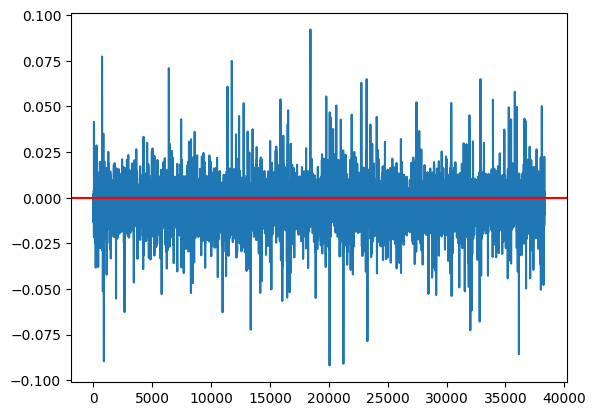

In [56]:
# train_ser = pd.Series(train_return, index=idx).dropna().sort_index()
train_ser = pd.Series(train_return, index=idx).dropna().reset_index(drop=True)
train_ser.plot()
plt.axhline(0, c='r')

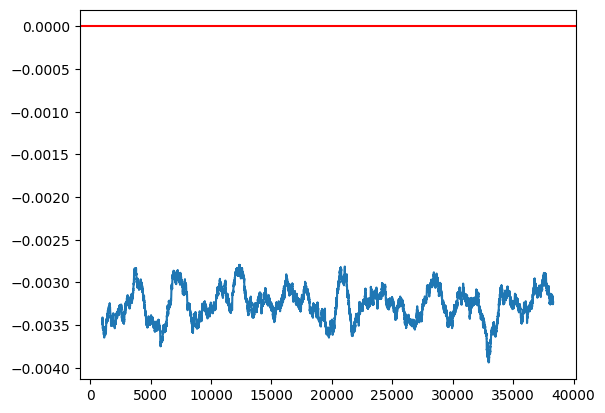

In [57]:
train_ser.rolling(1000).mean().plot()
plt.axhline(0, c='r')

In [58]:
train_ser

0       -0.001153
1       -0.004348
2       -0.013371
3       -0.004118
4        0.000405
           ...   
38301   -0.000802
38302   -0.002946
38303   -0.007678
38304    0.022372
38305   -0.004757
Length: 38306, dtype: float64

In [59]:
(train_ser > 0).mean()

0.1824518352216363

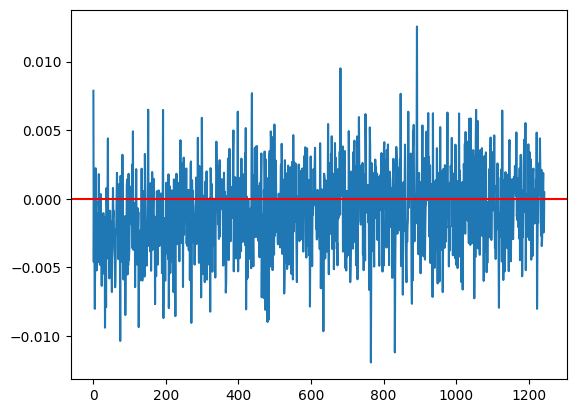

In [60]:
#eval_ser = pd.Series(eval_return, index=idx).dropna().sort_index()
eval_ser = pd.Series(eval_return, index=idx).dropna().reset_index(drop=True)
eval_ser.plot()
plt.axhline(0, c='r')

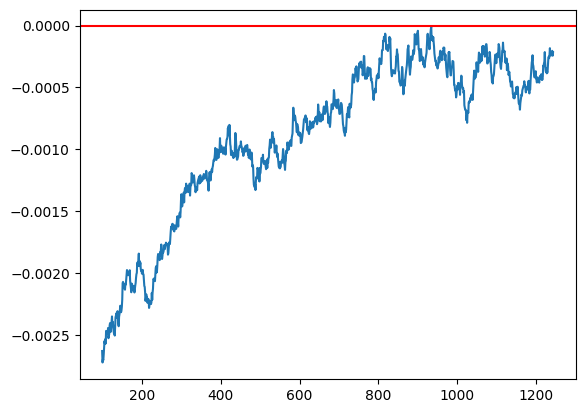

In [61]:
eval_ser.rolling(100).mean().plot()
plt.axhline(0, c='r')

In [62]:
eval_ser

0       0.007877
1      -0.004594
2       0.001186
3      -0.004418
4      -0.008021
          ...   
1239    0.000647
1240    0.001881
1241   -0.002454
1242   -0.002198
1243    0.000465
Length: 1244, dtype: float64

In [50]:
np.isnan(eval_return).mean()

0.8709677419354839

In [51]:
(eval_ser > 0).mean()

0.96875

<AxesSubplot:ylabel='Frequency'>

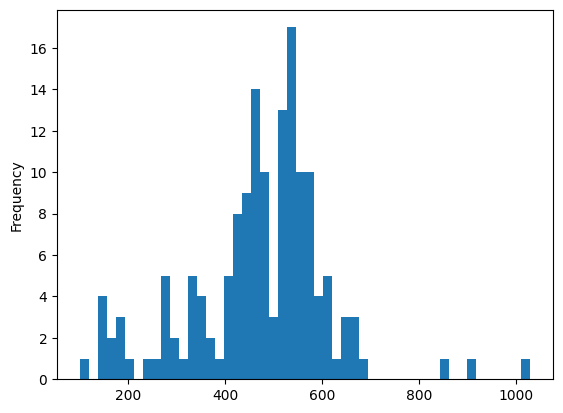

In [52]:
(train_ser).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

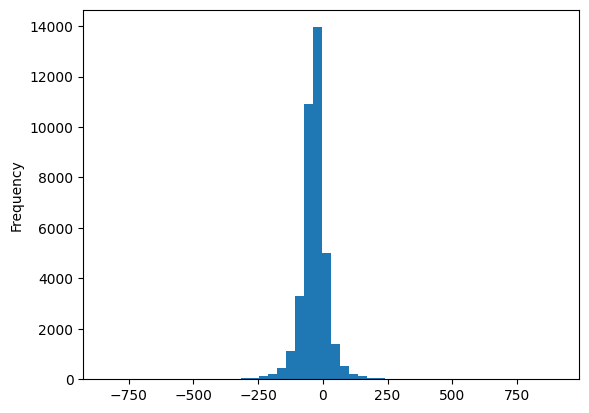

In [39]:
(train_ser*10000).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

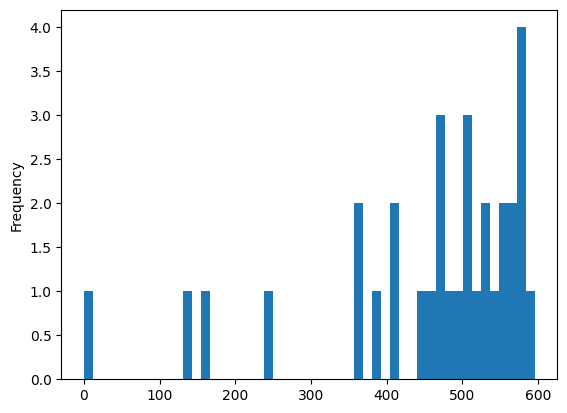

In [53]:
(eval_ser).plot.hist(bins=50)

<AxesSubplot:ylabel='Frequency'>

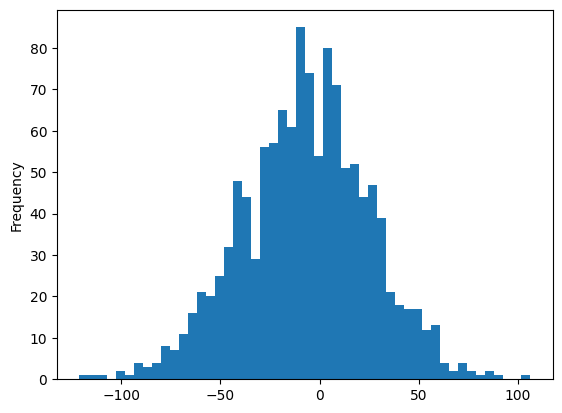

In [40]:
(eval_ser*10000).plot.hist(bins=50)

In [26]:
print('average trade (train, eval)')
train_ser.mean(), eval_ser.mean()

average trade (train, eval)


(-0.0032335981849732584, -0.00011602375087879932)

# Inspect More Closely

In [58]:
sorted(glob(f'logdir/{run}/train_eps/*'))[-4000]

'logdir/pong_tenth_switchback/train_eps/20230622T015426-73703d78a89143268298d737c39a1231-326.npz'

In [59]:
train_dayret = {}
for f in tqdm(sorted(glob(f'logdir/{run}/train_eps/*'))[-4000:]):
    file = np.load(f)
    train_dayret[pd.to_datetime(file['time'][-1]).date()] = file['reward'].sum()
train_dayret = pd.Series(train_dayret)

  0%|          | 0/4000 [00:00<?, ?it/s]

In [60]:
train_dayret.mean()

-0.0030836328

<AxesSubplot:>

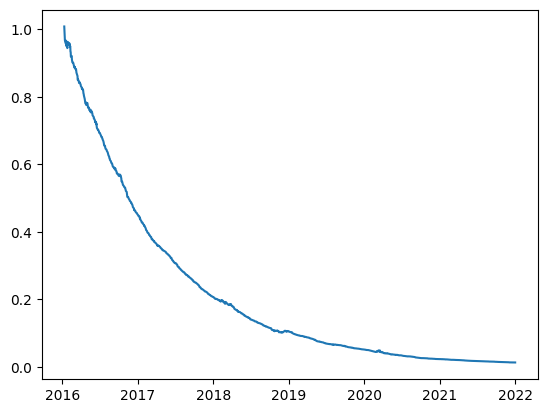

In [62]:
(train_dayret.sort_index() + 1).cumprod().plot()

In [45]:
sorted(glob(f'logdir/{run}/eval_eps/*'))[-1000]

'logdir/pong_tenth_switchback/eval_eps/20230622T052336-d6fdebbe7d0646f5add9d21b8866377e-326.npz'

In [46]:
eval_dayret = {}
for f in tqdm(sorted(glob(f'logdir/{run}/eval_eps/*'))[-1000:]):
    file = np.load(f)
    eval_dayret[pd.to_datetime(file['time'][-1]).date()] = file['reward'].sum()
eval_dayret = pd.Series(eval_dayret)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [51]:
eval_dayret.mean()

-0.0005008954

<AxesSubplot:>

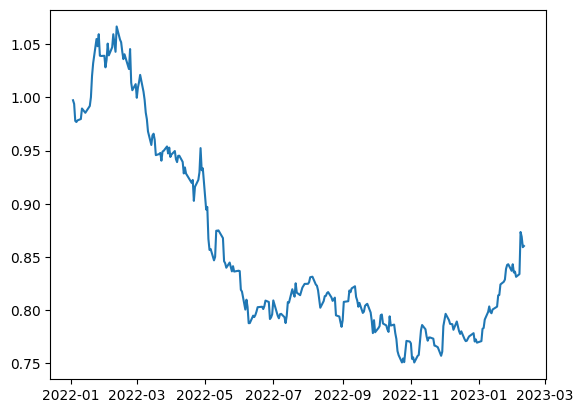

In [50]:
(eval_dayret.sort_index() + 1).cumprod().plot()

In [30]:
# eval_dayret = {
#     pd.to_datetime(os.path.basename(f).split('-')[0]):
#     np.load(f)['reward'].sum() for f in
#     tqdm(sorted(glob(f'logdir/{run}/eval_eps/*')))
# }

<AxesSubplot:>

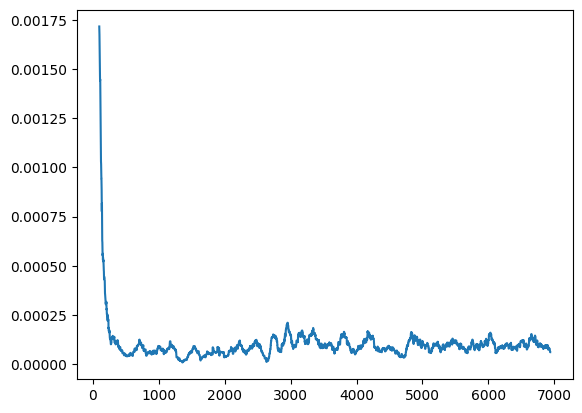

In [304]:
pd.Series(eval_dayret).reset_index(drop=True).rolling(100).mean().plot()

In [305]:
# eval_eps = np.random.choice(glob('logdir/pong_tenth_switchback/eval_eps/*'))
# eval_eps

# # eval_eps = 'logdir/pong/train_eps/20230605T205313-6add4faf62314205aaeea72b3477c69d-326.npz'
# eval_data = np.load(eval_eps)
# # eval_data.files

In [306]:
def filegen():
    yield from reversed(sorted(glob(f'logdir/{run}/eval_eps/*')))

In [307]:
episodes = filegen()

2023-06-11 23:42:46


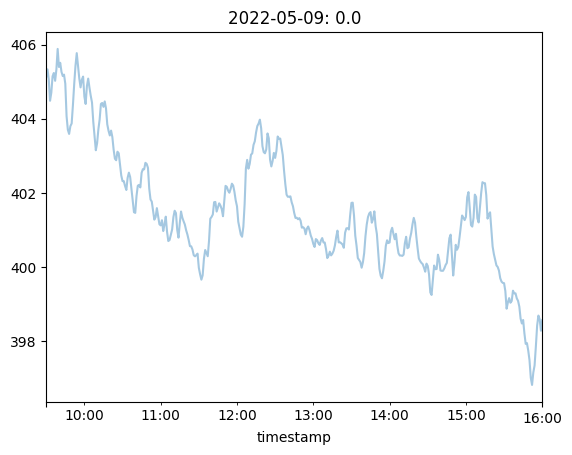

In [318]:
eval_eps = next(episodes)
eval_data = np.load(eval_eps)
print(pd.to_datetime(os.path.basename(eval_eps).split('-')[0]))

times = pd.to_datetime(eval_data['time'], utc=True).tz_convert('America/New_York')

pos = pd.Series(eval_data['pos'] - 1)
action = pos.diff()
action.iat[0] = pos.iloc[0]
action.index = times
action = action[action != 0]

date = times[-1].date()
start = pd.Timestamp.combine(date, datetime.time(hour=9, minute=30)).tz_localize('America/New_York')
end = pd.Timestamp.combine(date, datetime.time(hour=16)).tz_localize('America/New_York')
bars = api.get_bars('SPY', '1min',
                    start=start.isoformat(),
                    end=end.isoformat()).df
bars.index = bars.index.tz_convert('America/New_York')

ohlc = bars[['open', 'high', 'low', 'close']].mean(axis=1)

fig, ax = plt.subplots()
ohlc.plot(ax=ax, alpha=0.4)
ax.scatter(action.index, ohlc.loc[action.index], color=list(map({-1:'r', 1:'g'}.get, action)), s=10)
ax.set_title(f'{date}: {eval_data["reward"].sum()}')
plt.show()